<a href="https://colab.research.google.com/github/BogdanTurbal/writeright/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"gmkfdngkdm"

'gmkfdngkdm'

In [1]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import numpy as np
import os
import cv2
import skimage as sk
#import data_loader_cyrillic as dt
import pandas as pd
import copy

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)    

In [ ]:
class Preprocessor:
    def __init__(self, image_size, characters):
        (self.image_width, self.image_height) = image_size
        self.characters = characters
        self.padding_token = len(characters) + 1
        self.used = 0
       # print(f"padding token {self.padding_token}")
        
    def distortion_free_resize(self, image, img_size, vertical=False):
        w, h = img_size
        if vertical:
            print('dist')
            image = tf.image.flip_left_right(image)
            image = tf.transpose(image, perm=[1, 0, 2])
            
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
        
    # Check tha amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top = height + 1
            pad_height_bottom = height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left = width + 1
            pad_width_right = width
        else:
            pad_width_left = pad_width_right = pad_width // 2
        cnst = tf.math.reduce_mean(image)
        image = tf.pad(
            image,
            constant_values=cnst,
            paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0]]
            #mode="REFLECT"
            #[0, 0]
            
        )

        image = tf.transpose(image, perm=[1, 0, 2])
        image = tf.image.flip_left_right(image)
        return image
    def preprocess_image(self, image_path, label):
        img_size=(self.image_width, self.image_height)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)
        vert = False
        if tf.get_static_value(tf.size(label)) > 3 and tf.shape(image)[0] > tf.shape(image)[1]:
            self.used += 1
            vert = True
        image = self.distortion_free_resize(image, img_size, vertical=vert)
        image = tf.cast(image, tf.float32) / 255.0
        return image


    def vectorize_label(self, label):
        label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        ##
        length = tf.shape(label)[0]
        pad_amount = self.max_len - length
        label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=self.padding_token)
        ##
        return label


    def process_images_labels(self, image_path, label):
        image = self.preprocess_image(image_path, label)
        label = self.vectorize_label(label)
        return {"image": image, "label": label}
    
    def prepare_dataset(self, image_paths, labels, batch_size, char_to_num, max_len):
        self.char_to_num = char_to_num
        #self.padding_token = self.char_to_num('|')
        self.max_len = max_len
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
            self.process_images_labels, num_parallel_calls=AUTOTUNE
        )
        print(self.used)
        return dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
class DataLoader:
    def __init__(self, img_dir, labels_path, image_size, batch_size = 64):
        self.base_image_path = self.base_path = img_dir
        self.batch_size = batch_size
        self.preprocessor = None
        self.image_size = image_size
        self.labels_path = labels_path
       
    def get_base_lines(self):
        words = pd.read_csv(self.labels_path, encoding = 'utf-8')
        print(words)
        return words
    
    def get_image_paths_and_labels(self, samples):
        paths = []
        corrected_samples = []

        for i in range(samples.shape[0]):
            paths.append(self.base_path + '/' + samples['image_path'][i])
            corrected_samples.append(samples['label'][i])

        return paths, corrected_samples
    
    def clean_labels(self, labels, metrics=False):
        cleaned_labels = []
        characters = set()
        max_len = 0
        for label in labels:
            #label = label.split(" ")[-1].strip()
            if metrics:
                for char in label:
                    characters.add(char)
                max_len = max(max_len, len(label))
            cleaned_labels.append(label)
        if metrics:
            if '+' not in characters:
                characters.add('+')
            characters = sorted(list(characters))
            return cleaned_labels, characters, max_len
        else:
            return cleaned_labels
    
    
    def get_datasets(self):
        labels_df = self.get_base_lines()
        labels_df = labels_df.sample(frac = 1, random_state=42).reset_index(drop=True)

        print(labels_df.head())

        split_idx = int(0.9 * labels_df.shape[0])

        train_samples = labels_df.loc[:split_idx, :].reset_index(drop=True)
        test_samples = labels_df.loc[split_idx:, :].reset_index(drop=True)

        val_split_idx = int(0.15 * test_samples.shape[0])

        validation_samples = test_samples.loc[:val_split_idx, :].reset_index(drop=True)
        test_samples = test_samples.loc[val_split_idx:, :].reset_index(drop=True)
        
        train_img_paths, train_labels = self.get_image_paths_and_labels(train_samples)
        validation_img_paths, validation_labels = self.get_image_paths_and_labels(validation_samples)
        test_img_paths, test_labels = self.get_image_paths_and_labels(test_samples)
        
        del train_samples
        del validation_samples
        del test_samples
        train_labels_cleaned, characters, max_len = self.clean_labels(train_labels, metrics=True)
        validation_labels_cleaned = self.clean_labels(validation_labels)
        test_labels_cleaned = self.clean_labels(test_labels)
        self.preprocessor = Preprocessor(self.image_size, characters)
        
        del train_labels
        del validation_labels
        del test_labels

        # Mapping characters to integers.
        print(list(characters))
        char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

        # Mapping integers back to original characters.
        num_to_char = StringLookup(
            vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
        )
        #self.preprocessor.char_to_num = char_to_num
        #self.preprocessor.padding_token = padding_token
        
        train_ds = self.preprocessor.prepare_dataset(train_img_paths, train_labels_cleaned, self.batch_size, char_to_num, max_len)
        validation_ds = self.preprocessor.prepare_dataset(
            validation_img_paths, validation_labels_cleaned, self.batch_size, char_to_num, max_len)
        test_ds = self.preprocessor.prepare_dataset(test_img_paths, test_labels_cleaned, self.batch_size, char_to_num, max_len)
        
        return {'train_ds':train_ds, 'validation_ds': validation_ds, 
                'test_ds':test_ds, "characters": characters, 
                "num_to_char": num_to_char, "char_to_num": char_to_num, 
               "max_len": max_len}

In [ ]:
base_path = '/content/drive/MyDrive/project/'

In [ ]:
import zipfile
#GET AUGMENTED DATSET
zip_ref = zipfile.ZipFile(base_path + 'dataset_.zip', 'r')
zip_ref.extractall("./")
zip_ref.close()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
image_width = 256
image_height = 64
path_data = 'dataset_/data/'

In [ ]:
d_t = DataLoader(path_data, 'dataset_/data.tsv', (image_width, image_height), batch_size=64)
dict_dt = d_t.get_datasets()

       Unnamed: 0      image_path       label
0               0     dem2019.png       место
1               1      ax2678.png          м.
2               2      pe1683.png  Заряженная
3               3    test1289.png  24.11.1986
4               4    www11835.png   константы
...           ...             ...         ...
98812       98812     dem5550.png  образуется
98813       98813  synth_4210.png   укоренити
98814       98814     yob6416.png       енным
98815       98815     www9710.png      других
98816       98816       ann76.png        Юлия

[98817 rows x 3 columns]
   Unnamed: 0    image_path         label
0       73299   yob3972.png    караульный
1       45808   dbs1743.png  но правильно
2       68540  dem15300.png       участок
3       11897   ahh1344.png    показатель
4        4151    as1690.png       венного
[' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'І', 'А', 'Б', 'В', 'Г', 'Д',

In [ ]:
train_ds = dict_dt['train_ds']
validation_ds = dict_dt['validation_ds']
test_ds = dict_dt['test_ds']
num_to_char = dict_dt['num_to_char']
char_to_num = dict_dt['char_to_num']
characters = dict_dt['characters']
max_len = dict_dt['max_len']
unt_ds = train_ds.concatenate(test_ds)

In [ ]:
num_of_characters = len(list(characters))
padding_token = num_of_characters + 1
print(num_of_characters)

92


In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:
for i in range(1):
    print("".join(list(map(lambda x: x.decode("UTF-8"), num_to_char(validation_labels[2][i]).numpy()))))
    print(" ".join(list(map(lambda x: str(x), validation_labels[2][i].numpy()))))

загрязнения[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
66 59 62 75 90 66 72 64 72 67 90 93 93 93 93 93 93 93 93 93 93 93 93 93 93 93 93 93


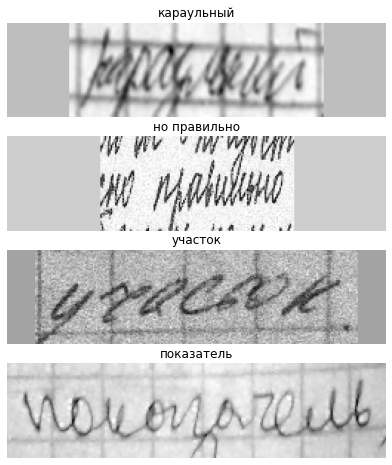

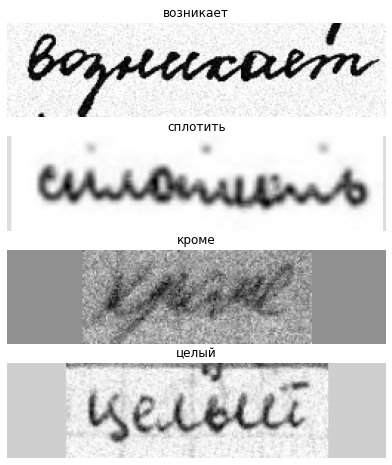

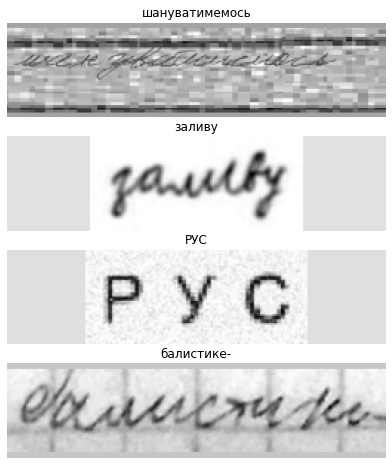

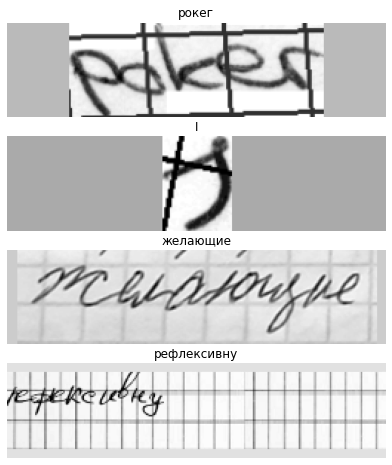

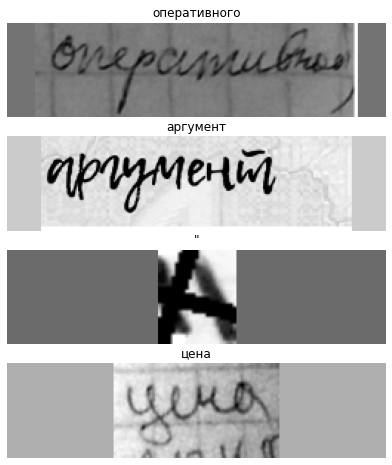

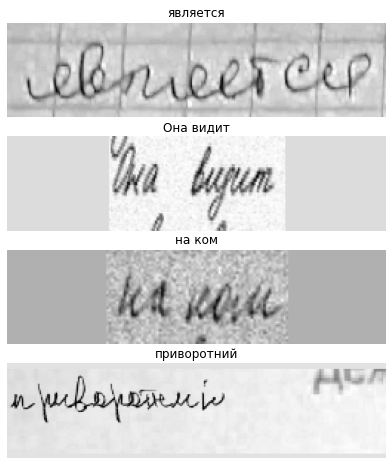

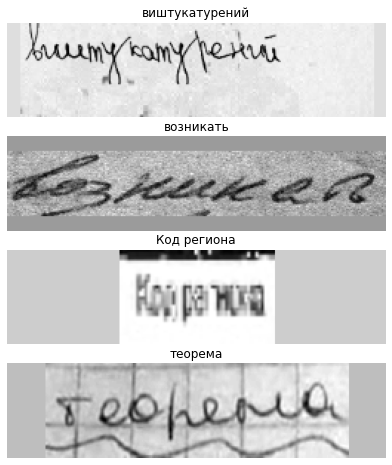

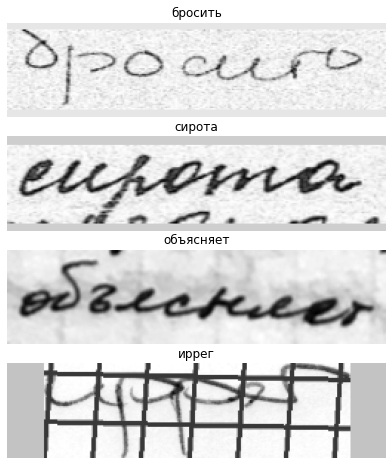

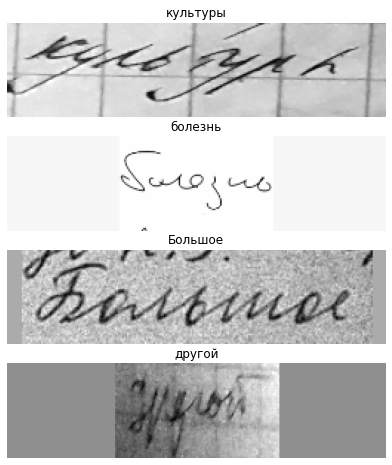

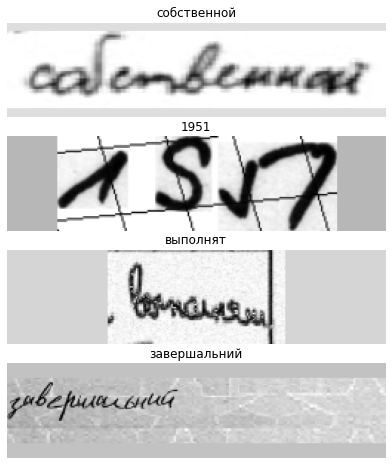

In [ ]:
for data in train_ds.take(10):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 1, figsize=(15, 8))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(label)
        ax[i].axis("off")
plt.show()

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [ ]:
def max_pooling(input, image_height=image_height):
    res = layers.MaxPool2D(pool_size=(1, image_height), padding='valid')(input)
    res = tf.squeeze(res, axis = 2)
    return res

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
            layers.Dropout(0.15)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def get_model(image_width=image_width, image_height=image_height):
    input_imgs = layers.Input(name="image", shape=(image_width, image_height, 1,))
    labels = layers.Input(name="label", shape=(None,))
    x = layers.Conv2D(8, 5, padding='same', activation='relu', name='filter')(input_imgs)

    x = keras.layers.Dropout(0.15)(x)
    
    x = layers.Conv2D(16, (2, 4), padding='same', activation='relu')(x)
    delt = layers.Conv2D(16, 3, padding='same', activation='sigmoid')(x)
    x = tf.keras.layers.Multiply(name='write')([x, delt])
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),padding='same')(x)

    x = keras.layers.Dropout(0.15)(x)
    x = layers.Conv2D(32, 5, padding='same', activation='relu')(x)
    delt = layers.Conv2D(32, 5, padding='same', activation='sigmoid')(x)
    x = x * delt
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    x = keras.layers.Dropout(0.2)(x)
    #jkjdfkjdkfjkdjf
    x = layers.Conv2D(64, (2, 4), padding='same', activation='relu')(x)
    delt = layers.Conv2D(64, 3, padding='same', activation='sigmoid')(x)
    x = x * delt
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 4), strides=(2, 4),padding='same')(x)

    x = keras.layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    #x = layers.BatchNormalization()(x)
    ##----##
    x = max_pooling(x, image_height=(image_height // 16))
    
    dim = 128
    x = layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    #new_shape = ((image_width // 4), (image_height // 8) * 128)
    #x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    ##----##
    x = layers.Dense(256, activation='relu')(x)
    x = TokenAndPositionEmbedding(maxlen=(image_width // 8), vocab_size=num_of_characters + 2, embed_dim=256)(x)

    x = TransformerBlock(256, 4, 256)(x)
    x = TransformerBlock(256, 4, 256)(x)
    x = TransformerBlock(256, 4, 256)(x)
    x = TransformerBlock(256, 4, 256)(x)

    x = layers.Dense(num_of_characters + 2, activation='softmax', name='end_dense')(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    
    model = tf.keras.models.Model(
        inputs=[input_imgs, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    learning_rate = CustomSchedule(256)
    opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    #opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    global_lens = tf.map_fn(fn=lambda tn: len(tf.where(tn != padding_token)), elems=labels)
    global_len = tf.math.reduce_sum(global_lens).numpy()

    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    np_decod = predictions_decoded.numpy()
    np_decod[np.where(np_decod == -1)] = padding_token
    predictions_decoded = tf.Variable(np_decod)

    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )

    return tf.math.reduce_sum(edit_distances).numpy() / global_len

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model, dataset_img, dataset_lbl):
        super().__init__()
        self.prediction_model = pred_model
        self.dataset_img = dataset_img
        self.dataset_lbl = dataset_lbl

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.dataset_img)):
            labels = self.dataset_lbl[i]
            predictions = self.prediction_model.predict(self.dataset_img[i], verbose=0)
            edit_distances.append(calculate_edit_distance(labels, predictions))

        print(
            f" Mean edit distance for epoch(augmentad) {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [ ]:
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 64

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  
    save_weights_only=True,
    save_freq=5*batch_size)

In [ ]:
model = get_model()
model.load_weights('transformer_0_1_it_40_w.h5')
model.summary()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 filter (Conv2D)                (None, 256, 64, 8)   208         ['image[0][0]']                  
                                                                                                  
 dropout_216 (Dropout)          (None, 256, 64, 8)   0           ['filter[0][0]']                 
                                                                                                  
 conv2d_105 (Conv2D)            (None, 256, 64, 16)  1040        ['dropout_21

In [ ]:
for prd in preds:
    _, _ = pred_img(prd)

TypeError: ignored

In [ ]:
epochs = 60  # To get good results this should be at least 50.
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels)

# Train the model.
history = model.fit(
    unt_ds,
    validation_data=validation_ds,
    initial_epoch=45,
    epochs=epochs,
    callbacks=[edit_distance_callback, cp_callback],
)

Epoch 46/60
1522/1522 [==============================] - 312s 205ms/step - loss: 4.1046 - val_loss: 3.4847
Epoch 47/60
1522/1522 [==============================] - 297s 195ms/step - loss: 3.9898 - val_loss: 3.4442
Epoch 48/60
  30/1522 [..............................] - ETA: 4:58 - loss: 3.8097

KeyboardInterrupt: ignored

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels)
history_ = model.fit(
    unt_ds,
    validation_data=validation_ds,
    initial_epoch=65,
    epochs=75,
    callbacks=[edit_distance_callback],
)

Epoch 66/75
1522/1522 [==============================] - 293s 192ms/step - loss: 3.6228 - val_loss: 3.2721
Epoch 67/75
1522/1522 [==============================] - 290s 190ms/step - loss: 3.5588 - val_loss: 3.2875
Epoch 68/75
1522/1522 [==============================] - 290s 190ms/step - loss: 3.4678 - val_loss: 3.2510
Epoch 69/75
1522/1522 [==============================] - 294s 193ms/step - loss: 3.3979 - val_loss: 3.1987
Epoch 70/75
1522/1522 [==============================] - 291s 191ms/step - loss: 3.3367 - val_loss: 3.2206
Epoch 71/75
  95/1522 [>.............................] - ETA: 4:21 - loss: 3.1835

KeyboardInterrupt: ignored

In [ ]:
epochs = 20  # To get good results this should be at least 50.
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels)

# Train the model.
history = model.fit(
    unt_ds,
    validation_data=validation_ds,
    #initial_epoch=15,
    epochs=epochs,
    callbacks=[edit_distance_callback, cp_callback],
)

Epoch 1/20
1468/1468 [==============================] - 340s 200ms/step - loss: 3.7165 - val_loss: 3.2672
Epoch 2/20
1468/1468 [==============================] - 283s 193ms/step - loss: 3.7284 - val_loss: 3.5412
Epoch 3/20
1468/1468 [==============================] - 284s 193ms/step - loss: 4.0765 - val_loss: 3.6880
Epoch 4/20
1468/1468 [==============================] - 285s 194ms/step - loss: 4.0699 - val_loss: 3.6189
Epoch 5/20
1468/1468 [==============================] - 285s 194ms/step - loss: 3.9216 - val_loss: 3.4592
Epoch 6/20
1468/1468 [==============================] - 286s 195ms/step - loss: 3.7614 - val_loss: 3.3302
Epoch 7/20
1468/1468 [==============================] - 287s 195ms/step - loss: 3.6384 - val_loss: 3.3193
Epoch 8/20
1468/1468 [==============================] - 285s 194ms/step - loss: 3.5137 - val_loss: 3.3115
Epoch 9/20
1468/1468 [==============================] - 282s 192ms/step - loss: 3.4259 - val_loss: 3.1842
Epoch 10/20
1468/1468 [=======================

In [ ]:
model.load_weights('transformer_0_1_it_20_w.h5')
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)
edit_distance_callback = EditDistanceCallback(prediction_model, validation_images, validation_labels)

In [ ]:
history_ = model.fit(
    unt_ds,
    validation_data=validation_ds,
    initial_epoch=20,
    epochs=50,
    callbacks=[edit_distance_callback, cp_callback],
)

Epoch 21/50
1468/1468 [==============================] - 300s 204ms/step - loss: 6.4394 - val_loss: 4.9558
Epoch 22/50
1468/1468 [==============================] - 290s 197ms/step - loss: 6.2953 - val_loss: 4.7797
Epoch 23/50
1468/1468 [==============================] - 293s 200ms/step - loss: 6.1695 - val_loss: 4.8232
Epoch 24/50
1468/1468 [==============================] - 293s 200ms/step - loss: 6.0196 - val_loss: 4.5584
Epoch 25/50
1468/1468 [==============================] - 292s 198ms/step - loss: 5.8959 - val_loss: 4.5984
Epoch 26/50
1468/1468 [==============================] - 295s 201ms/step - loss: 5.7895 - val_loss: 4.4245
Epoch 27/50
1468/1468 [==============================] - 296s 201ms/step - loss: 5.6892 - val_loss: 4.4117
Epoch 28/50
1468/1468 [==============================] - 292s 199ms/step - loss: 5.6122 - val_loss: 4.3821
Epoch 29/50
1468/1468 [==============================] - 291s 198ms/step - loss: 5.5755 - val_loss: 4.4154
Epoch 30/50
1468/1468 [==============

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('transformer_0_2_it_60_w.h5')

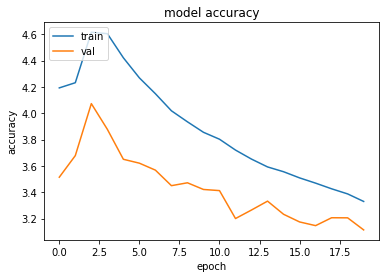

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 27ms/step


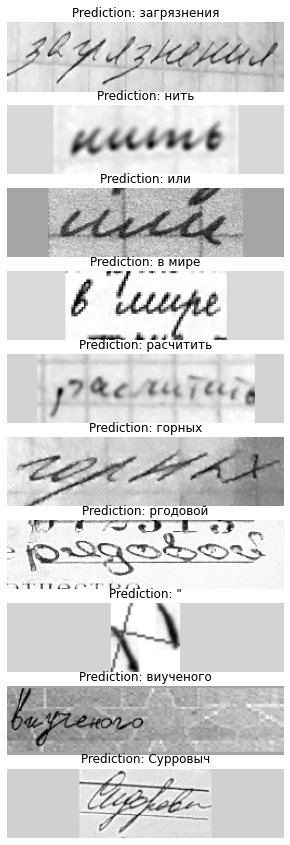

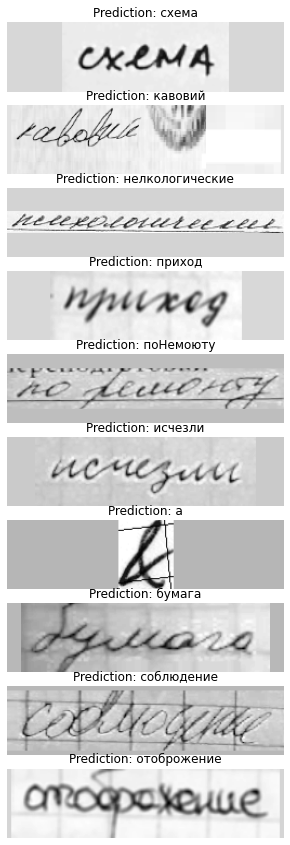

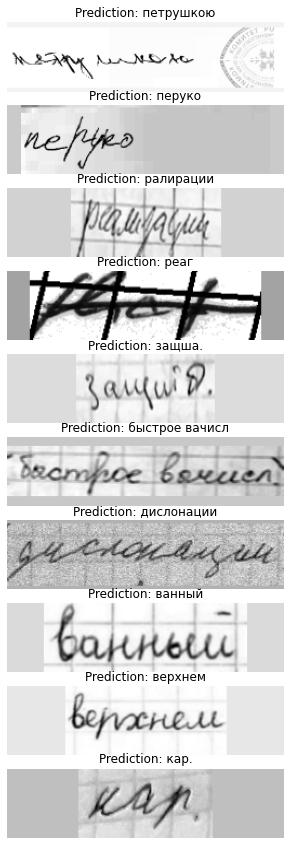

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
i = 0
for batch in validation_ds.take(5):
    if i < 2:
        i += 1
        continue
    batch_images = batch["image"]
    _, ax = plt.subplots(10, 1, figsize=(15, 15))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(10):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()

In [ ]:
def pred_img(path, model=prediction_model):
    img = np.array(tf.keras.utils.load_img(path, grayscale=True), dtype='float32')
    img = np.expand_dims(img, axis = -1)
    #_, ax = plt.subplots(1, 1, figsize=(30, 8))
    #ax.imshow(img[:, :, 0])
    pr = Preprocessor((256, 64), characters)

    img = pr.distortion_free_resize(img, (256, 64))
    img = np.expand_dims(img, axis = 0)
    img = tf.cast(img, dtype='float32').numpy() / 255
    img_ = copy.deepcopy(img)
    preds = prediction_model.predict(img, verbose=False)
    pred_texts = decode_batch_predictions(preds)
    
    #print(img.shape)
    img = tf.image.flip_left_right(img)
    #print(img.shape)
    img = tf.transpose(img[0], perm=[1, 0, 2])
    _, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.imshow(img[:, :, 0], cmap = "gray")
    ax.set_title(pred_texts[0])
    #print(pred_texts)
    return img_, pred_texts

In [ ]:
preds = ['img_0_0.png', 'img_0_1.png', 'img_0_2.png', 'img_0_3.png', 'img_0_4.png',
         'img_1_0.png', 'img_1_1.png', 'img_1_2.png', 'img_1_3.png', 'img_1_4.png',
         'pl2.png',
         'img_2_0.jpg', 'img_2_1.jpg', 'img_2_2.jpg', 'img_2_3.jpg', 'img_2_4.jpg', 'img_2_5.jpg', 'img_2_6.jpg', 'img_2_7.jpg',
         'img_3_0.jpg', 'img_3_1.jpg', 'img_3_2.jpg', 'img_3_3.jpg', 'img_3_4.jpg', 'img_3_5.jpg', 'img_3_6.jpg',]

In [ ]:
model.load_weights('transformer_0_1_it_20_w.h5')
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="end_dense").output
)

<ipython-input-72-6428aea68b90>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1, figsize=(15, 8))


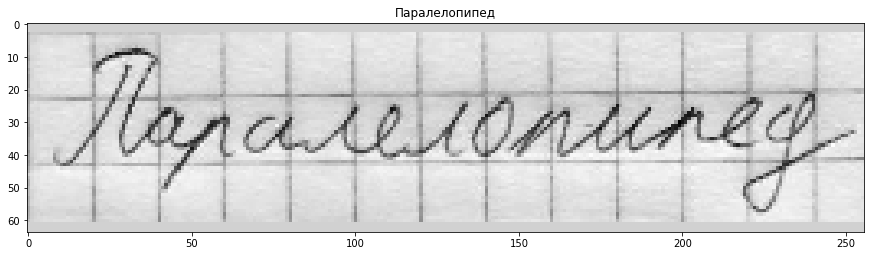

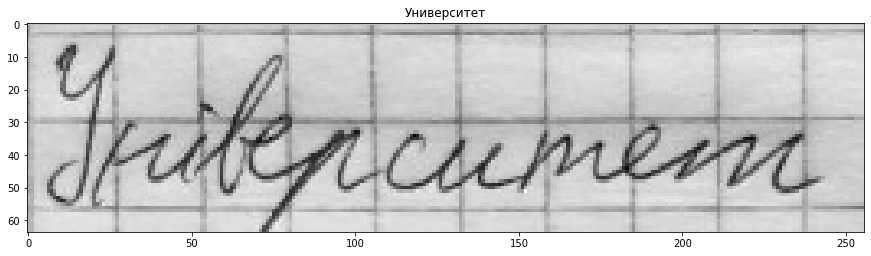

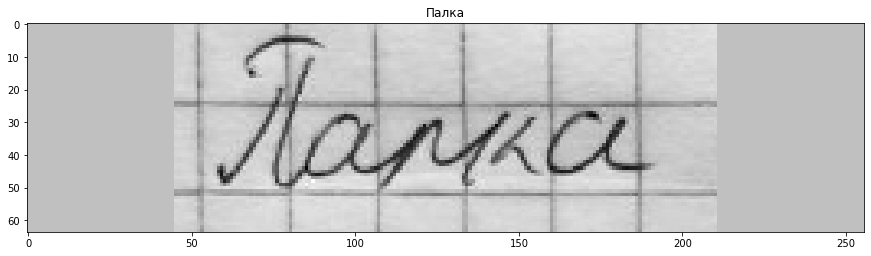

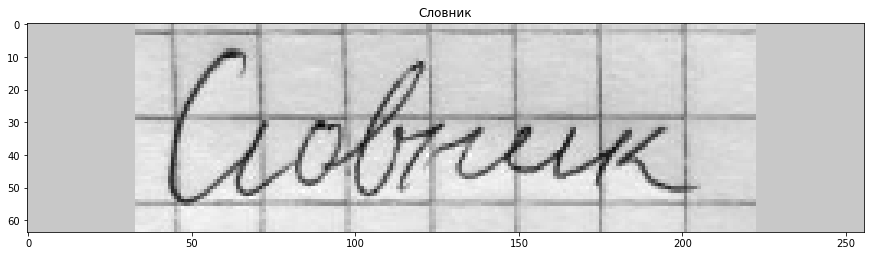

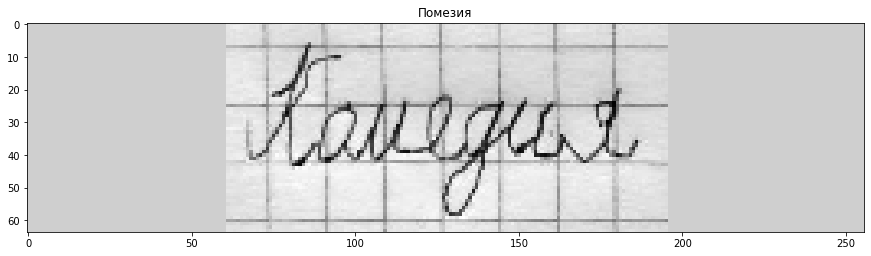

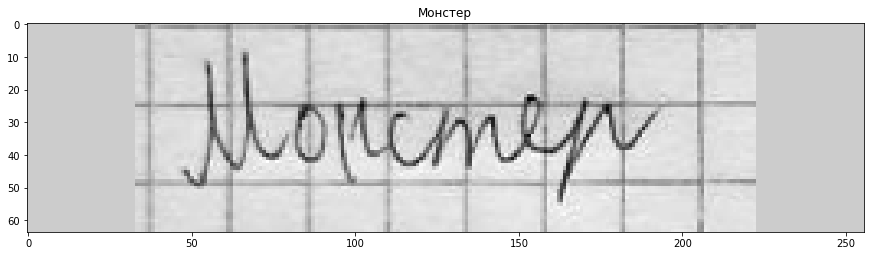

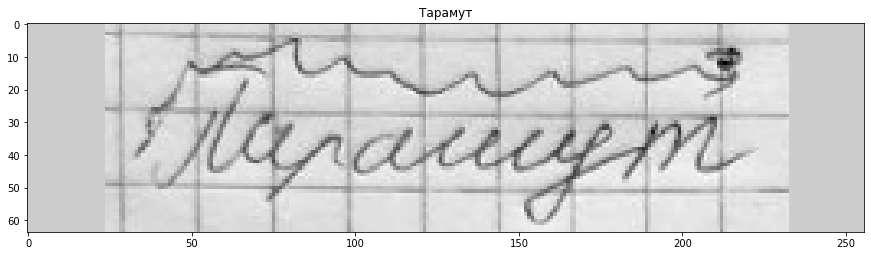

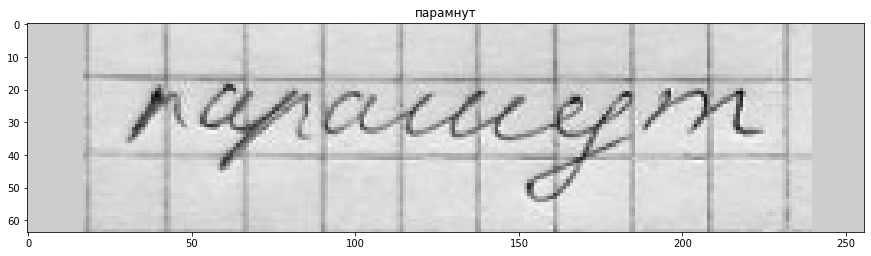

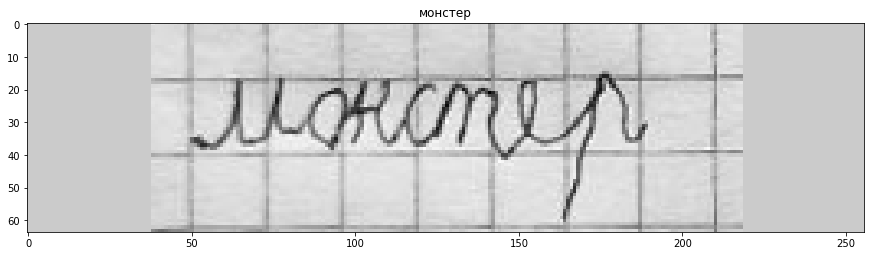

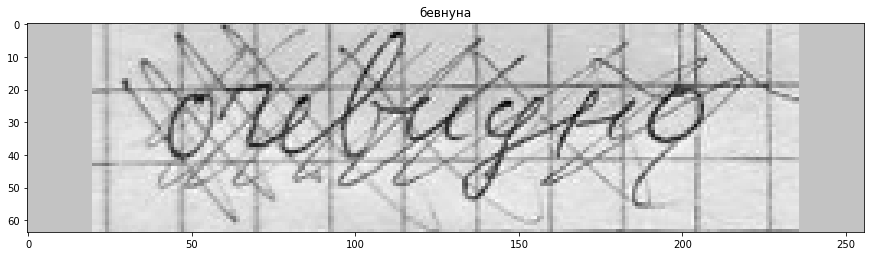

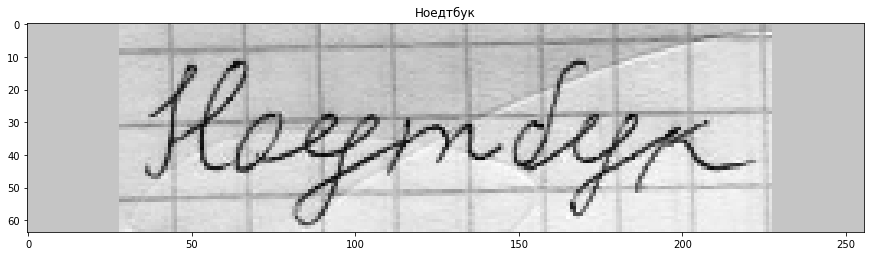

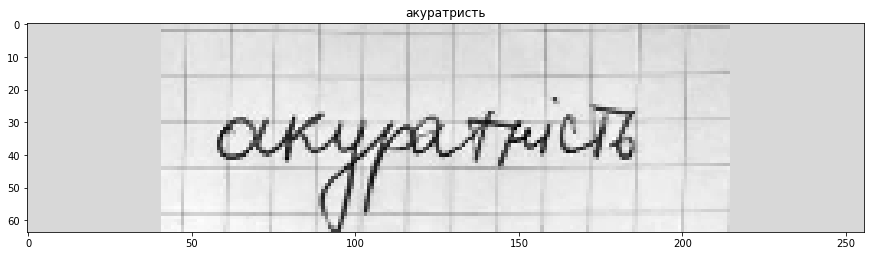

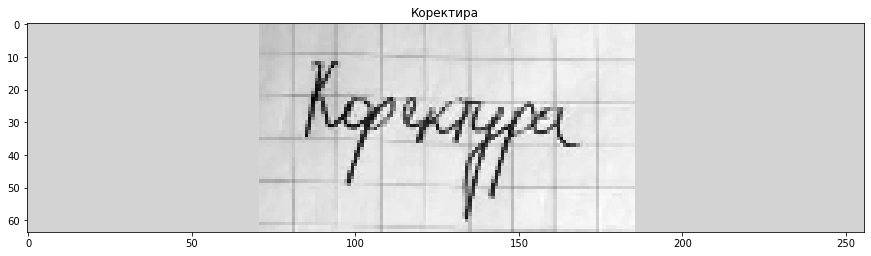

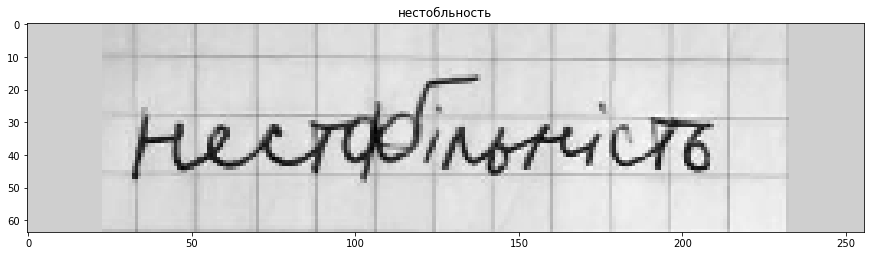

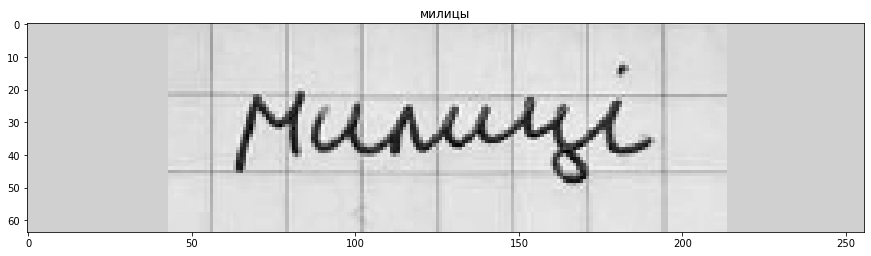

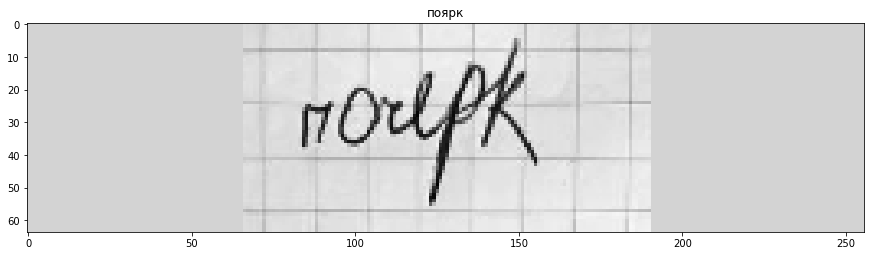

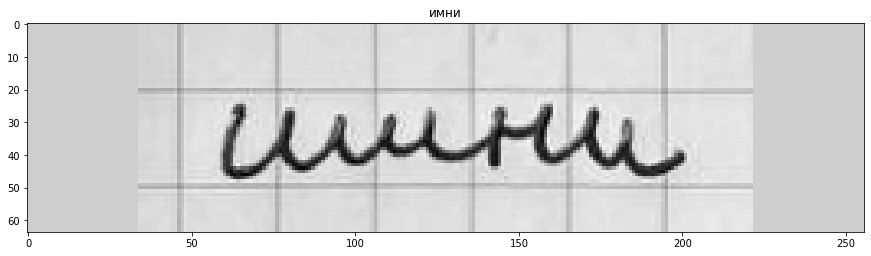

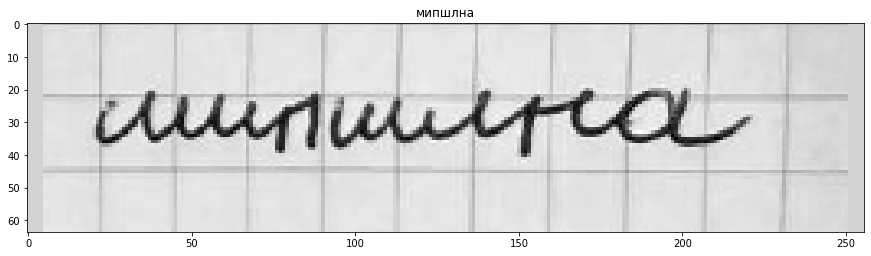

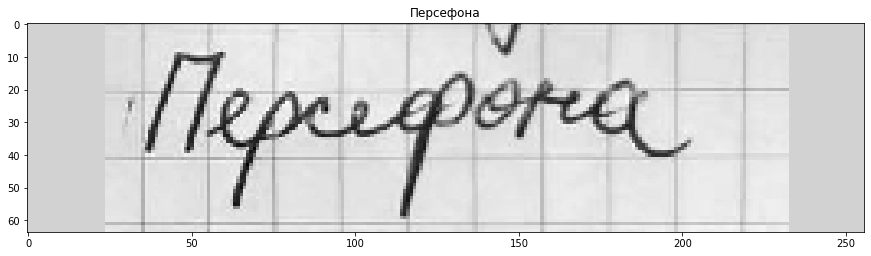

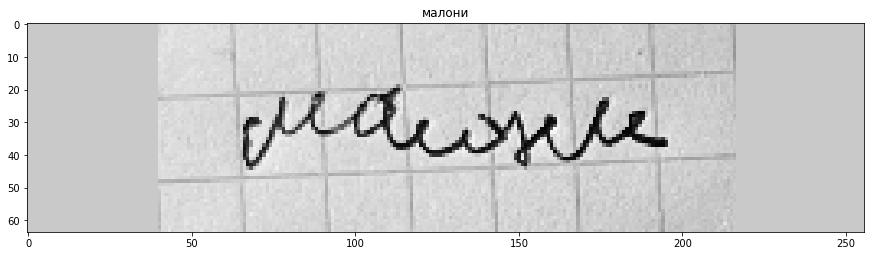

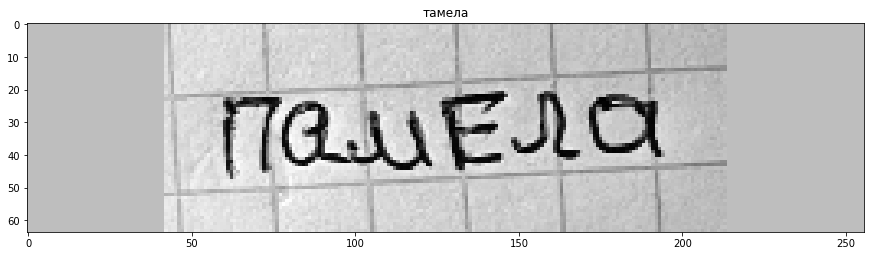

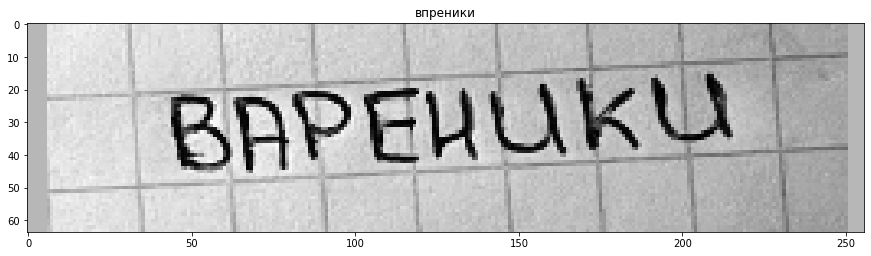

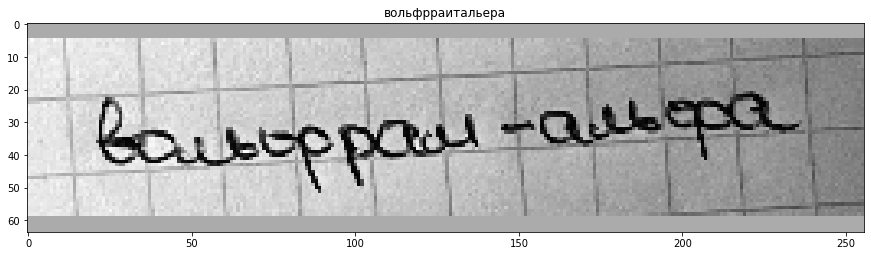

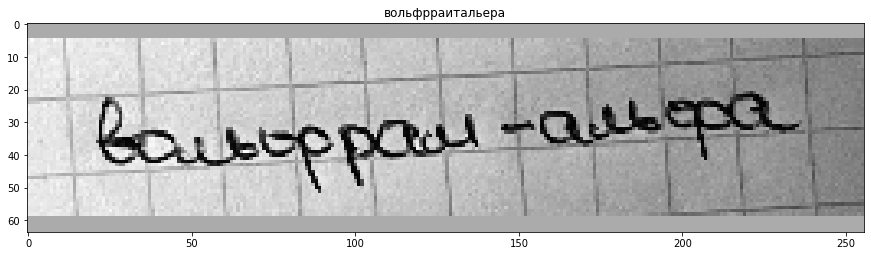

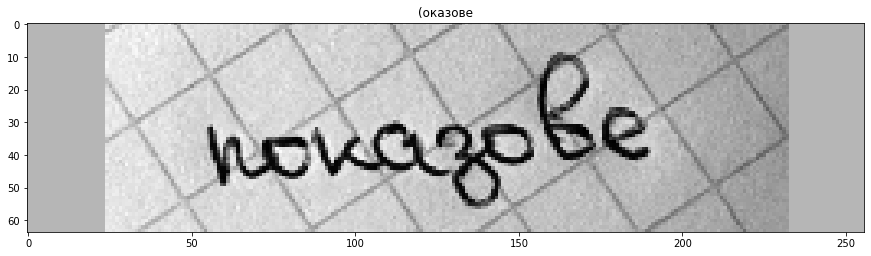

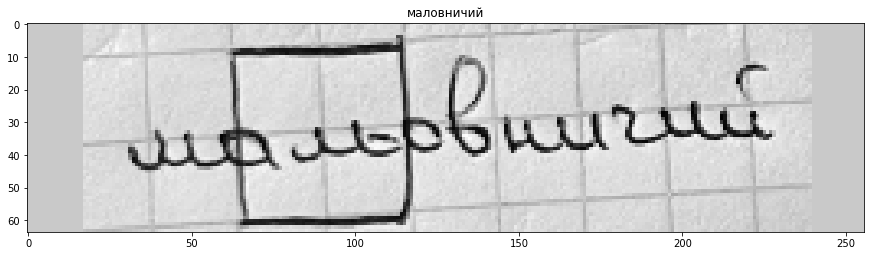

In [ ]:
for prd in preds:
    _, _ = pred_img(prd)

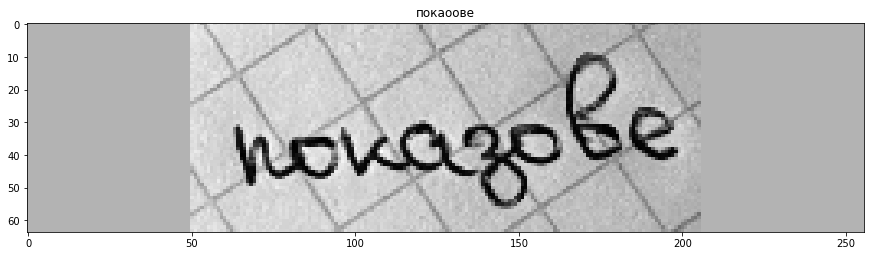